Plots for Minimal Packing Set manuscript

In [1]:
from gsd_lib import GSD, MinimalPackingGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget


In [2]:
# Standard U.S. sieve sizes (mm)
x1 = np.array(
    [
        0.0001,  # Pan
        0.075,  # Number 200 sieve separates coarse from fines
        0.15,
        0.3,
        0.6,
        1.18,
        2.36,
        4.75,  # Number 4 sieve separates sand from gravel
        9.5,
        19,
        25,
        37.5,
        50,
        63,
        75,  # 3-inch sieve (100% passing this per ASTM D2487-17 1.2)
    ]
)

x2 = np.array([0.0001, 0.075, 0.3, 2.36, 4.75, 25, 75])

x3 = np.array([0.075, 0.3, 2.36, 4.75, 25, 50, 75])

x = x1
n_sieves = len(x)

In [3]:
# Generate random grain size distributions on the sieve set
def mass_dist(n_sieves, rng=None, center=0.75, exponent=2.0):
    if rng is None:
        rng = np.random.default_rng()
    base_dist = rng.random(n_sieves)
    center_idx = rng.integers(1, center * n_sieves)
    distances = np.abs(np.arange(n_sieves) - center_idx) / center_idx
    scale_factor = np.exp(-exponent * distances)
    add = rng.random(n_sieves) * 0.005
    return base_dist * scale_factor + add

# A random generator with a fixed seed for reproducibility
rng = np.random.default_rng(1)

tol = 1e-3

gsd_list = []
set_size_list = []
flex_list = []
for i in range(500):
    # Create a distributed set of retained masses
    mass = mass_dist(n_sieves, rng)
    mass[-1] = 0.0  # Ensure last mass is zero
    g = GSD(sizes=x, masses=mass)
    # Create a set size minimal packing for each GSD
    s_set_size = MinimalPackingGenerator(
        g, x_n_factor=0.01, tol=tol, flex=False, density=1.0
    )
    # Create a flexible minimal packing for each GSD
    s_flex = MinimalPackingGenerator(
        g, x_n_factor=0.01, tol=tol, flex=True, density=1.0
    )
    gsd_list.append(g)
    set_size_list.append(s_set_size)
    flex_list.append(s_flex)


/Users/lornearnold/GitHub/discrete_analytical_mech/src/gsd_lib/generator.py:108: RuntimeWarning: invalid value encountered in cast
  q_minus = np.floor(self.kappa_minus * i).astype(int)


(0.055, 100)

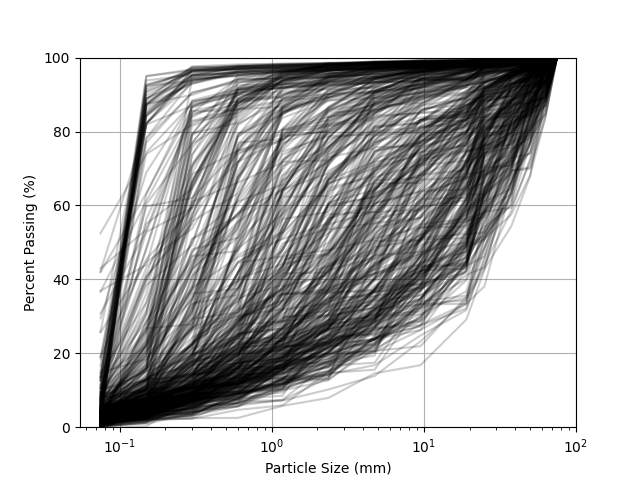

In [4]:
# Plot the grain size distributions
plt.close('all')
fig, ax = plt.subplots()
for gsd in gsd_list:
    ax.plot(gsd.sizes[1:], 100*gsd.percent_passing[1:], color='k', alpha=0.2)
ax.set_xscale('log')
ax.grid()#(True, which='both', axis='both')
ax.set_xlabel('Particle Size (mm)')
ax.set_ylabel('Percent Passing (%)')
ax.set_ylim(0, 100)
ax.set_xlim(0.055, 100)

The figure below shows the effectiveness of the spanning integer approach to finding the minimal packing set.
With the spanning integer approach, the error converges to zero rapidly (the final packing is generally not controlled by the user-specified tolerance) compared to the fixed size approach.


Text(0, 0.5, 'Norm. Freq.')

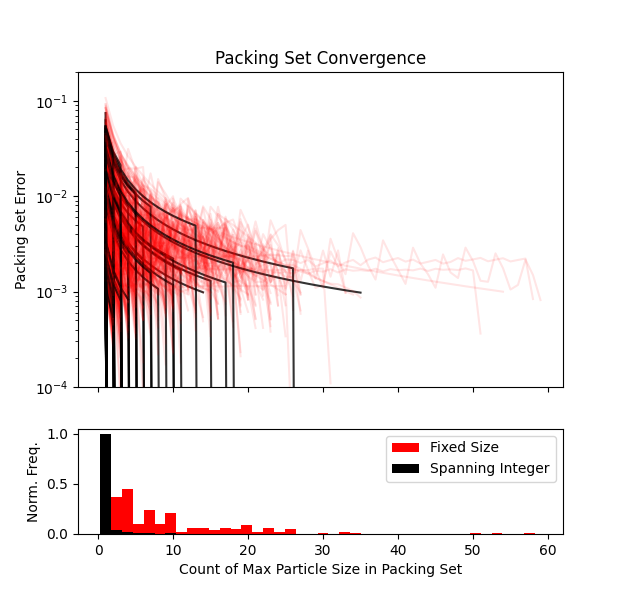

In [5]:
plt.close('all')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.25, 6), sharex=True, height_ratios=[3, 1])
j = 1
nf = []
ns = []
for i in range(len(flex_list)):
    f = flex_list[i]
    s = set_size_list[i]
    xf = [n[-1] for n in f.qs]
    xs = [n[-1] for n in s.qs]
    nf.append(xf[-1])
    ns.append(xs[-1])
    ax1.plot(xf,f.error, color='k', alpha=0.8)
    ax1.plot(xs,s.error,color="r", alpha=0.1)



# Calculate histograms
counts_ns, bins_ns = np.histogram(ns, bins=40)
counts_nf, bins_nf = np.histogram(nf, bins=bins_ns)

# Normalize to max frequency
norm_counts_ns = counts_ns / np.max(counts_ns)
norm_counts_nf = counts_nf / np.max(counts_nf)

# Plot normalized histograms
ax2.bar(
    bins_ns[:-1],
    norm_counts_ns,
    width=np.diff(bins_ns),
    alpha=1,
    label="Fixed Size",
    color="red",
)
ax2.bar(
    bins_nf[:-1],
    norm_counts_nf,
    width=np.diff(bins_nf),
    alpha=1,
    label="Spanning Integer",
    color="black",
)


ax1.set_yscale("log")
# ax1.set_xscale("log")
ax1.set_ylim(1e-4, 2e-1)
ax1.set_title("Packing Set Convergence")
ax1.set_ylabel("Packing Set Error")

# ax2.set_ylabel("Normalized Frequency (Max = 1)")
ax2.legend()
ax2.set_xlabel("Count of Max Particle Size in Packing Set")
ax2.set_ylabel("Norm. Freq.")

The next figure shows how the ratio of masses between the minimum and maximum particle sizes affects the overall sample size.

At this point, I want to stop showing the fixed size approach and focus on the spanning integer approach, which I will consider the minimal packing.

There's a fairly consistent exponential trend in min/max mass ratio and sample size for a group of packing sets based on the same sieve stack.
I'd like to truncate the applicable stacks so that there are different min/max size ratios. 
I suspect each of these will follow their own exponential trend.

The closer they line up, the less I think I'll need to look into trends with other gradation parameters (e.g., curvature, uniformity).


Other parameters to look at:
* max curvature
* concavity
* average curvature

What I'm really looking for is an explanation of what makes the sets above the minimum in each group (by number of sieves) higher than the minimum.
It seems like `n_sieves` and `mass_ratio` explain a lot, but I'd like to be able to explain more of the variation in sample size.

In [834]:
def add_data_row(data_rows, mpgen: MinimalPackingGenerator):
    """
    Adds a row to the DataFrame with the provided keyword arguments.
    Any missing columns will be filled with NaN.

    """
    sample = mpgen.mps
    total_particles = sum(sample.quantities)
    mass_max = sample.total_masses[-1]
    mass_min = sample.total_masses[0]
    mass_ratio = mass_min / mass_max
    percent_fines = mass_min / sum(sample.total_masses)

    size_max = sample.sizes[-1]
    size_min = sample.sizes[0]
    size_ratio = int(np.round(size_max / size_min, 0))

    row = {
        "GSD": mpgen.g,
        "n_sieves": len(sample.sizes),
        "mass_ratio": mass_ratio,
        "log_mass_ratio": np.log10(mass_ratio),
        "size_ratio": size_ratio,
        "log_size_ratio": np.log10(size_ratio),
        "vol_ratio": size_ratio**3,
        "log_vol_ratio": np.log10(size_ratio**3),
        "max_size": size_max,
        "min_size": size_min,
        "percent_fines": percent_fines,
        "total_particles": total_particles,
        "log_total_particles": np.log10(total_particles),
        "cc": np.round(mpgen.g.cc, 1),
        "cu": np.round(mpgen.g.cu, 1),
        "i_gs": mpgen.g.i_gs,
        "log_size": mpgen.g._i_gs_curve()[0],
        "gsd_curve": mpgen.g._i_gs_curve()[1],
        "max_curvature": mpgen.g.max_curvature,
        "max_positive_curvature": mpgen.g.max_positive_curvature,
        "max_negative_curvature": mpgen.g.max_negative_curvature,
        "average_curvature": mpgen.g.average_curvature,
        "concavity": np.mean(mpgen.g.concavity_on_log),  # + size_ratio**3,
        # Best so far: 
        "con_vol": (np.log10(size_ratio**3) - np.mean(mpgen.g.concavity_on_log)),#* np.log10(size_ratio)**2),
        "asdf":   np.log10(mass_ratio) + np.log10(size_ratio**3),
        "max_slope": mpgen.g.max_slope,
    }
    data_rows.append(row)
    pass

In [835]:
rng = np.random.default_rng(1)
data_rows = []

for i in range(1, len(x)-4):
    new_x = x[:-i]
    n_sieves = len(new_x)

    for j in range(500):
        # Create a distributed set of retained masses
        mass = mass_dist(n_sieves, rng)

        mass[-1] = 0.0  # Ensure last mass is zero
        # print(new_x)
        g = GSD(sizes=new_x, masses=mass)

        # Create a flexible minimal packing for each GSD
        mps = MinimalPackingGenerator(
            g, x_n_factor=0.5, tol=tol, flex=True, density=1.0
        )
        add_data_row(data_rows, mps)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data_rows)

Text(0, 0.5, 'con_vol')

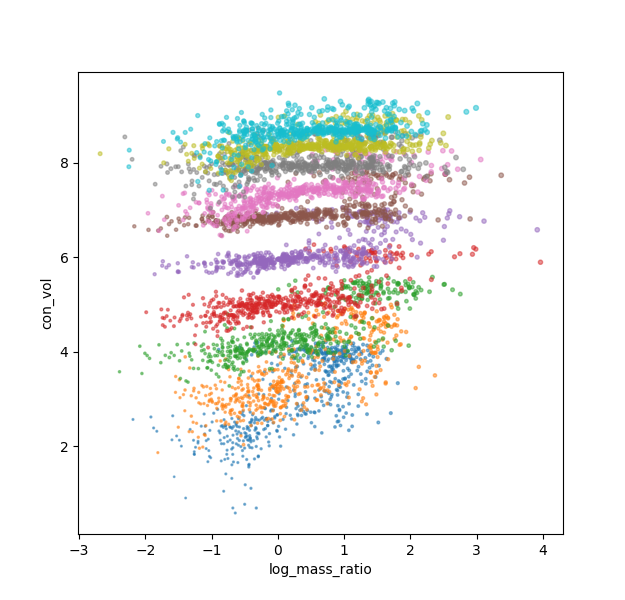

In [836]:
plt.close('all')
fig, ax = plt.subplots(figsize=(6.25, 6))

x_param = "log_mass_ratio"
y_param = "con_vol"
group_param = "n_sieves"
for size_ratio, group in df.groupby(group_param):
    ax.scatter(
        group[x_param],
        group[y_param],
        label=f"{group_param} {size_ratio}",
        alpha=0.5,
        s=group["log_total_particles"],  # Scale point size by log_total_particles
    )

# ax.legend(title=group_param)
b = 10
xx = np.linspace(-2, 3, 100)
yy = xx
# ax.plot(xx, yy, color='k', linestyle='--')

ax.set_xlabel(f"{x_param}")
ax.set_ylabel(y_param)
# ax.set_ylim(-2,2)
# ax.set_xscale("log")
# ax.set_yscale("log")

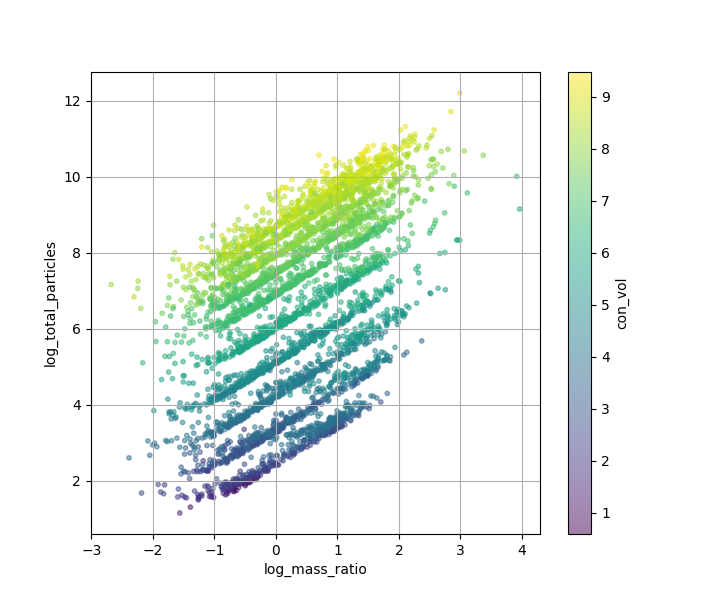

In [837]:
# c = q_ns, s = q_ns, cmap = "viridis"
color_param = "con_vol"
x_param = "log_mass_ratio"
y_param = "log_total_particles"

fig, ax = plt.subplots(figsize=(7.25, 6))
ax.scatter(
    df[x_param],
    df[y_param],
    c=df[color_param],
    s=10, 
    cmap="viridis",
    alpha=0.5,
)

# ax.legend(title="cu", loc='upper left', bbox_to_anchor=(1, 1))
colorbar = plt.colorbar(ax.collections[0], ax=ax)
colorbar.set_label(color_param)

ax.set_xlabel(f"{x_param}")
ax.set_ylabel(y_param)
# ax.set_xscale("log")
# ax.set_yscale("log")
ax.grid(True, which='both', axis='both')


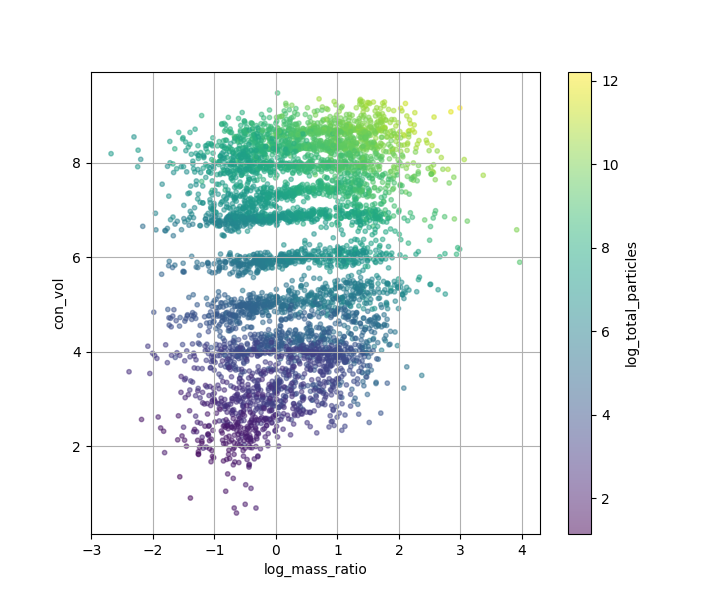

In [838]:
# c = q_ns, s = q_ns, cmap = "viridis"
color_param = "log_total_particles"
x_param = "log_mass_ratio"
y_param = "con_vol"

fig, ax = plt.subplots(figsize=(7.25, 6))
ax.scatter(
    df[x_param],
    df[y_param],
    c=df[color_param],
    s=10, 
    cmap="viridis",
    alpha=0.5,
)

# ax.legend(title="cu", loc='upper left', bbox_to_anchor=(1, 1))
colorbar = plt.colorbar(ax.collections[0], ax=ax)
colorbar.set_label(color_param)

ax.set_xlabel(f"{x_param}")
ax.set_ylabel(y_param)
# ax.set_xscale("log")
# ax.set_yscale("log")
ax.grid(True, which='both', axis='both')

Text(0, 0.5, 'GSD Curve')

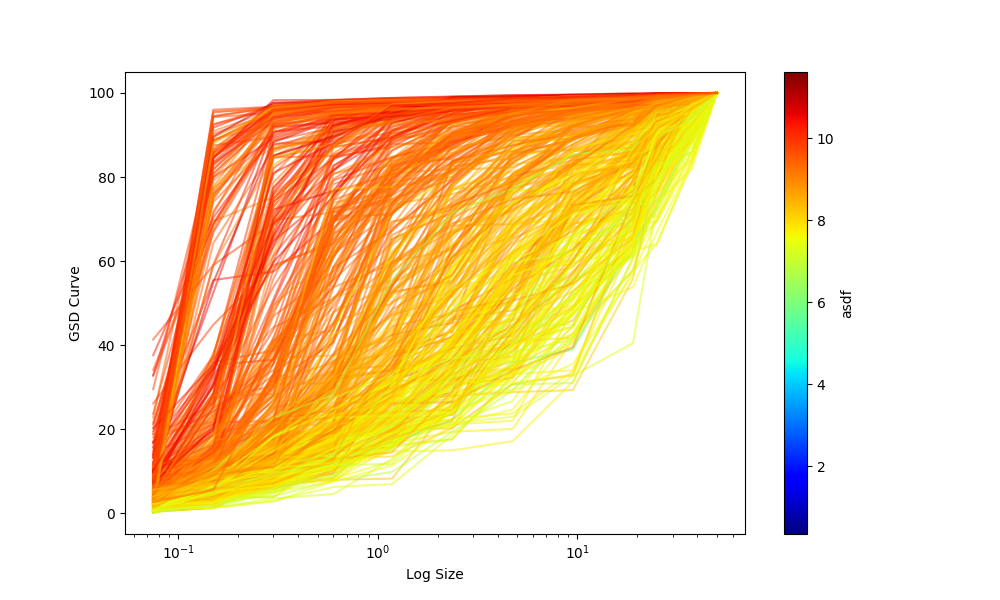

In [784]:
# c = q_ns, s = q_ns, cmap = "viridis"
fig, ax = plt.subplots(figsize=(10, 6))

color_param = "asdf"
color_index = df.columns.get_loc(color_param) +1

# Get the colormap
cmap = plt.cm.jet

# Normalize the i_gs values to [0, 1] range for the colormap
c_values = [row[color_index] for row in df.itertuples()]
c_min = min(c_values)
c_max = max(c_values)

n_sieves = [12]

for row in df.itertuples():
    x_data = row.GSD.sizes[1:]
    y_data = 100 * row.GSD.percent_passing[1:]

    # Normalize i_gs to [0, 1] range
    normalized_i_gs = (row[color_index] - c_min) / (c_max - c_min)

    # Get color from colormap
    color = cmap(normalized_i_gs)
    if row.n_sieves in n_sieves:
        ax.plot(x_data, y_data, color=color, alpha=0.5)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=c_min, vmax=c_max))
sm.set_array([])
colorbar = plt.colorbar(sm, ax=ax)
colorbar.set_label(color_param)

ax.set_xscale("log")
ax.set_xlabel("Log Size")
ax.set_ylabel("GSD Curve")


In [627]:
# # c = q_ns, s = q_ns, cmap = "viridis"
# fig, ax = plt.subplots(figsize=(10, 6))

# # Get the colormap
# cmap = plt.cm.viridis

# # Normalize the i_gs values to [0, 1] range for the colormap
# i_gs_values = [row.i_gs for row in df.itertuples()]
# i_gs_min = min(i_gs_values)
# i_gs_max = max(i_gs_values)

# for row in df.itertuples():
#     x_data = row.GSD.sizes[1:]
#     y_data = row.GSD.percent_passing[1:]

#     # Normalize i_gs to [0, 1] range
#     normalized_i_gs = (row.i_gs - i_gs_min) / (i_gs_max - i_gs_min)

#     # Get color from colormap
#     color = cmap(normalized_i_gs)

#     ax.plot(x_data, y_data, color=color, alpha=0.5)

# # Add colorbar
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=i_gs_min, vmax=i_gs_max))
# sm.set_array([])
# colorbar = plt.colorbar(sm, ax=ax)
# colorbar.set_label("i_gs")

# ax.set_xscale("log")
# ax.set_xlabel("Log Size")
# ax.set_ylabel("GSD Curve")
